In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import shap
import xgboost

%matplotlib inline

In [13]:
df = pd.read_csv("kc_house_data.csv")
df_clean = df.drop(columns=['date', 'id', 'zipcode'])
X, y = df_clean.drop(columns=['price']), df_clean['price']

# 1 Trenowanie modelu drzewiastego

Zaczniemy od Random Forest.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(bootstrap=True, max_depth=120, max_features='auto', n_estimators=1000, n_jobs=20, random_state=1)
scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_absolute_error')
scores

array([-70446.54688425, -67973.26225609, -67891.96208646, -69425.05490049,
       -72052.76345802])

In [12]:
print(f'Średnie MAE tego modelu: {scores.mean()}')

Średnie MAE tego modelu: -69472.60010165004


In [13]:
rf.fit(X, y)

RandomForestRegressor(max_depth=120, n_estimators=1000, n_jobs=20,
                      random_state=1)

# 2.1 Wybór obserwacji

In [10]:
ids = [0, 3, 5]
X.iloc[ids]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
6,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
8,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,47.5123,-122.337,1780,8113


Wybrałem te przykłady głównie z powodu na szeroki zakres `yr_built`. Drugie w kolejności były różnice w `condition` `grade`, `sqft_above` i `sqft_basement`.

In [11]:
y.iloc[ids]

1    538000.0
6    257500.0
8    229500.0
Name: price, dtype: float64

Zgodnie z przewidywaniami, ceny za podane domy drastycznie się od siebie różnią.

# 2.2 Usunięcie wierszy z danych treningowych i przetrenowanie modelu

In [12]:
X_obs = X.iloc[ids]
y_obs = y.iloc[ids]

X = X.drop(index=ids)
y = y.drop(index=ids)

rf = RandomForestRegressor(bootstrap=True, max_depth=120, max_features='auto', n_estimators=1000, n_jobs=20, random_state=1)

In [ ]:
rf.fit(X, y)

RandomForestRegressor(max_depth=120, n_estimators=1000, n_jobs=20,
                      random_state=1)

In [ ]:
rf.predict(X_obs)

array([ 254168.113     ,  481227.533     , 1380672.58433333])

# 3 Atrybucja cech

In [24]:
import shap

explainer = shap.TreeExplainer(rf, X, model_output='raw')
shap_values = explainer(X_obs)

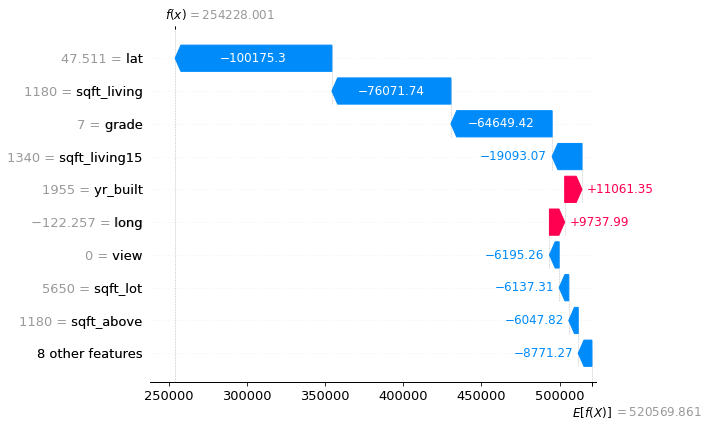

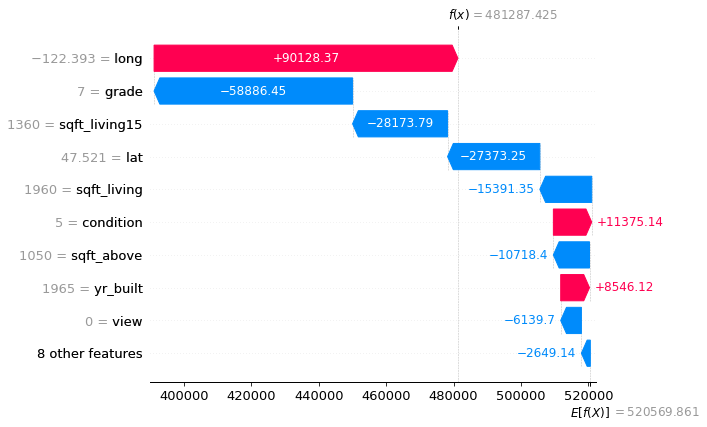

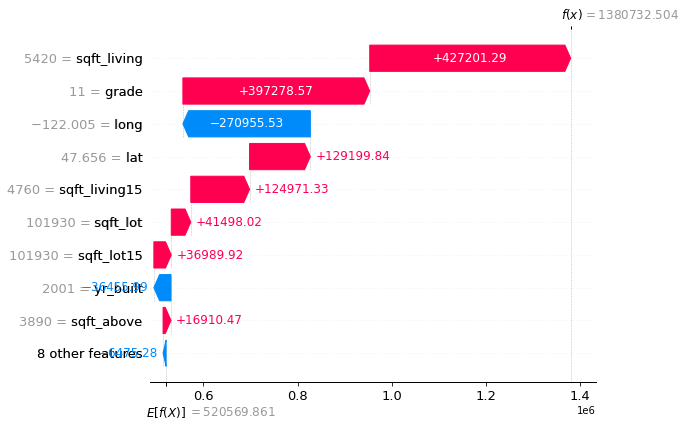

In [25]:
for i in range(3):
    shap.plots.waterfall(shap_values[i])

# 4 Różne obserwacje mają różne najbardziej kluczowe cechy

Widzimy, że w zasadzie każda obserwacja ma inny zestaw cech. Widać jednak pewne rozsądne zależności: np. wyższy `grade` (czyli "building construction and design") podbija cenę.
Niepokojące są cechy `long` i `lat`. W pierwszym i drugim przykładzie jest najważniejszą cechą, w trzecim jest w zasadzie tego samego rzędu wielkości co najważniejsze 3 cechy.
Szerokość i wysokość geograficzna powinna mieć wpływ na wynik, w końcu istnieją różnice między dzielnicami a nawet konkretnymi ulicami i mogą one wpływać na cenę domu.
W takim wypadku jednak najważniejszymi cechami powinien być stan danego domu (rok budowy, stan budynku, stan wnętrza, powierzchnia itd.) a położenie w danej dzielnicy powinno delikatnie zmieniać cenę.
Istnieje ryzyko że model uznał za lepsze z perspektywy optymalizacji metryki robienie splitów po cechach które jednoznacznie identyfikują wiersz.
Potencjalne rozwiązania tej sytuacji to:
1. wyrzucić `long` i `lat`, przetrenować model i zobaczyć rozkład cech.
2. wprowadzić pewne rozsądne uogólnienie które nie pozwala jednoznacznie identyfikować mieszkania, np. podzielić miasto na strefy i przekazywać do modelu informacje o strefie

# 6 Gradient boosting

In [ ]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, nthread=12, objective='reg:squarederror', subsample=0.7, verbosity=0)
xgb.fit(X.to_numpy(), y.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12, nthread=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [26]:
explainer_xgb = shap.TreeExplainer(xgb, X, model_output='raw')
shap_values_xgb = explainer_xgb(X_obs)

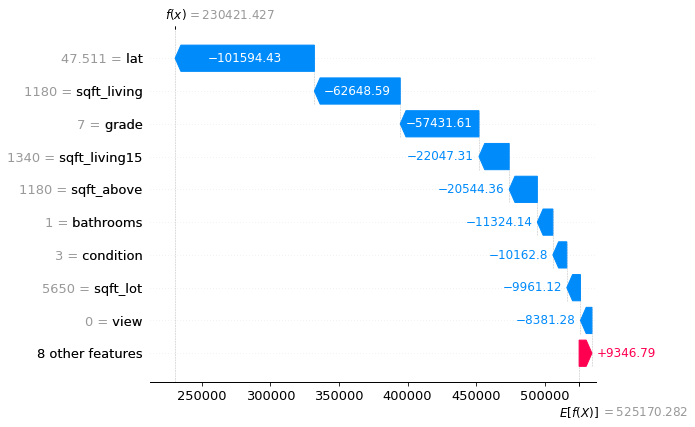

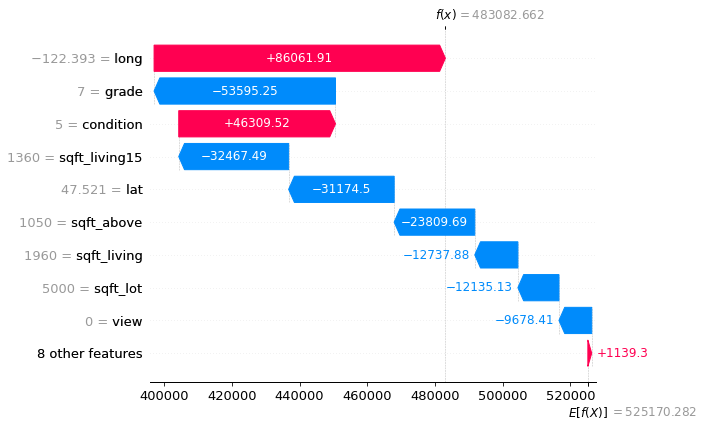

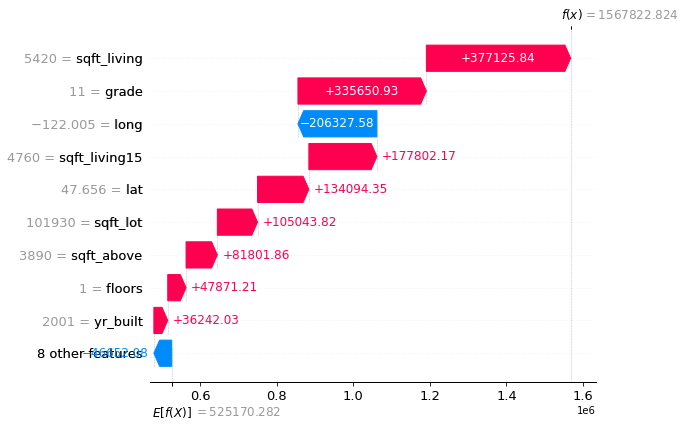

In [27]:
for i in range(3):
    shap.plots.waterfall(shap_values_xgb[i])

Dla każdej pary (obserwacja Random Forest, obserwacja XGB) top2 cechy są identyczne. Dalej widoczny jest problem z `lat` i `long`.
Przejrzałem koło 30 przykładów i nie byłem wstanie znaleźć dwóch sytuacji gdzie modele miały istotnie różną atrybucje.